# outlier detection

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
from sklearn.manifold import TSNE
import umap
import mpld3

full_data = np.load("FINAL_DATA.npy")

full_data.shape
reshaped_data = full_data.reshape(2500, 784)

weird_points = [1781, 536, 1145, 533, 1720, 1328, 1156, 722, 904, 360, 124, 842, 1859, 2496, 392, 1038, 947, 2322, 156, 2138, 193, 2140, 572, 1414]
def plot_lc(emedded_mat, title, outliers=None, baseline_outliers=weird_points, save_plot=False):
    x = emedded_mat[:, 0]
    y = emedded_mat[:, 1]
    fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))
    ax.set_xlabel('feature 1')
    ax.set_ylabel('feature 2')
    N = len(x)
    hehe = []
    s = []
    shapes = []
    for i in range(N):
        if i == 1156:
            hehe.append('r')
            s.append(80)
        if i in baseline_outliers:
            hehe.append('g')
            s.append(30)
            shapes.append("x")
        else:
            hehe.append("#660066")
            s.append(1)
            shapes.append(".")
        
    hehe = np.array(hehe)
    s = np.array(s)
    
    scatter = ax.scatter(x,
                         y,
                         c=hehe,
                         s=s,
                         alpha=0.3,
                         zorder=10)
    ax.grid(color='white', linestyle='solid', zorder=0)

    ax.set_title(title, size=15)
    
    if save_plot:
        plt.savefig("final_images/" + str(title) +".ps", dpi=1500)

    labels = ['point {0}'.format(i + 1) for i in range(N)]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)

In [2]:
# TSNE STUFF
p = 120
ee = 12
lr = 100

model_tsne_2 = TSNE(n_components=2, perplexity=p, early_exaggeration=ee, learning_rate=lr)
embeddings_tsne_784_2 = model_tsne_2.fit_transform(reshaped_data)
print model_tsne_2.kl_divergence_

0.262722492218


In [3]:
neighbors = 70
min_dist = 1.0

model_umap_2 = umap.UMAP(n_neighbors=neighbors, min_dist=min_dist)
embeddings_umap_784_2 = model_umap_2.fit_transform(reshaped_data)

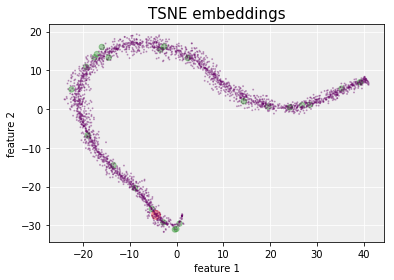

In [4]:
plot_lc(embeddings_tsne_784_2, "TSNE embeddings", save_plot=True)

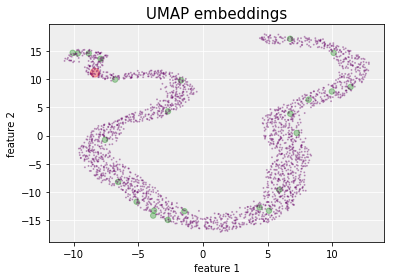

In [5]:
plot_lc(embeddings_umap_784_2, "UMAP embeddings", save_plot=True)

# final outliers finding

In [13]:
from sklearn.metrics import pairwise_distances
from scipy.spatial import cKDTree

kdata = np.load('KeplerSampleFullQ.npy',encoding='bytes')


def real_plot(num):
    x = kdata[num][0]
    y = kdata[num][1]
    y_err = kdata[num][2]
    plt.errorbar(x, y, yerr=y_err,fmt=".")
    plt.show()

def find_outliers(distances, metric='min', name="test", show_outliers=True, cutoff=3, limit=10, title=None, savefig=False, r=1):
    if metric == 'ball':
        scores = []
        if r is None:
            r = 1
        lookup_tree = cKDTree(embeddings_tsne_784_2)
        ball_count = []
        print r
        for point in embeddings_tsne_784_2:
            ball_count.append(len(lookup_tree.query_ball_point(point, r)))
        distribution = np.array(ball_count)
        average = np.mean(distribution)
        std = np.std(distribution)
        normalized = np.apply_along_axis(lambda x: (x-average)/std, 0, distribution)
        plt.title("NNeighbors in Ball of radius" + str(r) + "distance distribution for embedding: " + name)
        plt.hist(normalized, bins=100)
        plt.show()
        outliers = [i for i, _ in enumerate(normalized) if normalized[i] > cutoff]
        if neg_cutoff:
            for i, _ in enumerate(normalized):
                if normalized[i] < neg_cutoff:
                    outliers.append(i)
        
        if show_outliers:
            count = 0
            for i in outliers:
                count += 1
                if count > limit:
                    break
                plt.title("outlier " + str(i) + " for embeddings: " + name)
                real_plot(i)
                print normalized[i]
        return outlier, scores
    elif metric == 'average':
        scores = []
        distribution = np.mean(distances, axis=1)
        average = np.mean(distribution)
        std = np.std(distribution)
        normalized = np.apply_along_axis(lambda x: (x-average)/std, 0, distribution)
        if title is None:
            plt.title("mean distance distribution for embedding: " + name)
        else:
            plt.title(title)
        plt.hist(normalized, bins=100)
        if savefig:
            plt.ylabel('Frequency')
            plt.xlabel('Normalized Nearest Neighbor Distance')
            plt.savefig("final_images/"+title + ".ps", dpi=100)
        plt.show()
        outliers = [i for i, _ in enumerate(normalized) if normalized[i] > cutoff]
        if show_outliers:
            count = 0
            for i in outliers:
                count += 1
                if count > limit:
                    break
                plt.title("outlier " + str(i) + " for embeddings: " + name)
                real_plot(i)
                print normalized[i]
        return outliers, scores
    elif metric == 'min':
        scores = []
        distribution = []
        for i, _ in enumerate(distances):
            min_elem = np.min(np.concatenate((distances[i,:i], distances[i, i+1:]), axis=None))
            distribution.append(min_elem)
        distribution = np.array(distribution)
        average = np.mean(distribution)
        std = np.std(distribution)
        normalized = np.apply_along_axis(lambda x: (x-average)/std, 0, distribution)
        if title is None:
            plt.title("min distance distribution for embedding: " + name)
        else:
            plt.title(title)
        plt.hist(normalized, bins=100)
        if savefig:
            plt.ylabel('Frequency')
            plt.xlabel('Normalized Nearest Neighbor Distance')
            plt.savefig("final_images/" + title + ".ps", dpi=100)
        plt.show()
        outliers = [i for i, _ in enumerate(normalized) if normalized[i] > cutoff]
        if show_outliers:
            count = 0
            for i in outliers:
                count += 1
                if count > limit:
                    break
                plt.title("outlier " + str(i) + " for embeddings: " + name)
                real_plot(i)
                print normalized[i]
                scores.append((i, normalized[i]))
        return outliers, scores, normalized, distribution

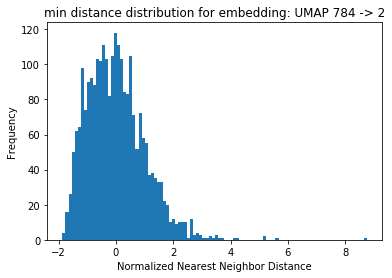

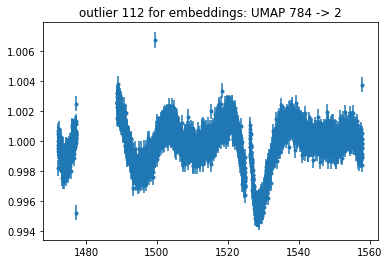

3.701518


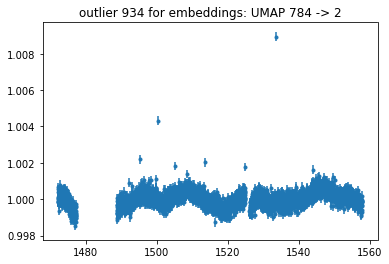

4.2696724


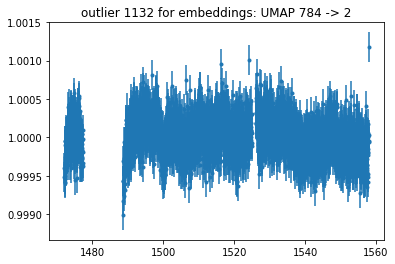

5.1466312


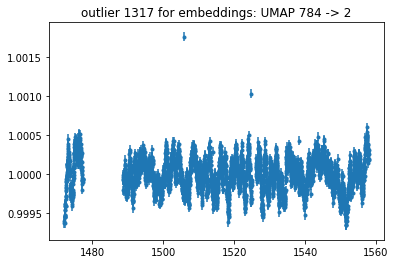

3.6438541


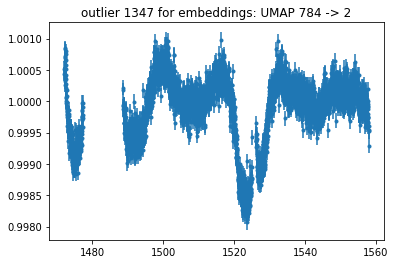

8.750384


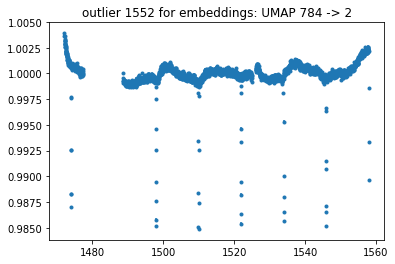

4.134793


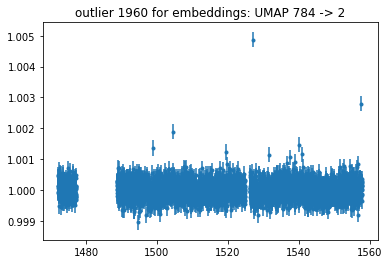

5.1549544


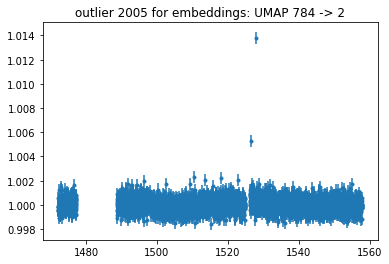

3.5425956


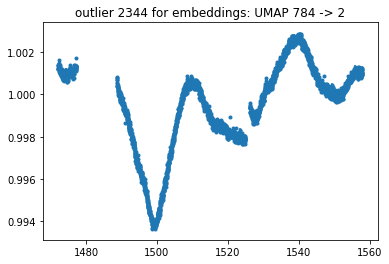

5.5921526


In [29]:
distances = pairwise_distances(embeddings_umap_784_2)
umap_outliers, umap_scores, umap_norm_distribution, umap_raw_scores = find_outliers(distances, name="UMAP 784 -> 2", title="min distance distribution for embedding: UMAP 784 -> 2", metric='min', cutoff=3.53, savefig=True)





In [30]:
print("OUTLIERS: ")
print(umap_outliers)
print("SCORES OF OUTLIERS:")
print(umap_scores)
print("MEAN RAW SCORE, MEDIAN RAW SCORE")
print(str(np.mean(umap_raw_scores)) + ", " + str(np.median(umap_raw_scores)))
print("MEAN NORMALIZED SCORE, MEDIAN NORMALIZED SCORE")
print(str(np.mean(umap_norm_distribution)) + ", " + str(np.median(umap_norm_distribution)))

OUTLIERS: 
[112, 934, 1132, 1317, 1347, 1552, 1960, 2005, 2344]
SCORES OF OUTLIERS:
[(112, 3.701518), (934, 4.2696724), (1132, 5.1466312), (1317, 3.6438541), (1347, 8.750384), (1552, 4.134793), (1960, 5.1549544), (2005, 3.5425956), (2344, 5.5921526)]
MEAN RAW SCORE, MEDIAN RAW SCORE
0.15271182, 0.14615849
MEAN NORMALIZED SCORE, MEDIAN NORMALIZED SCORE
-1.2130738e-07, -0.08101463


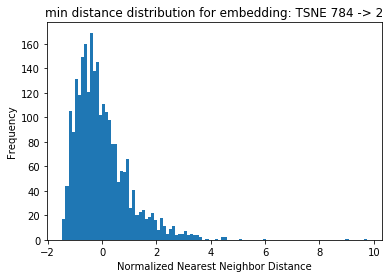

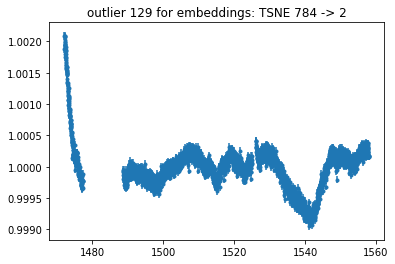

9.034252


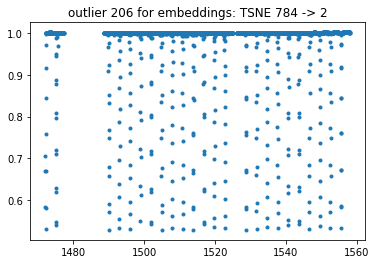

9.740791


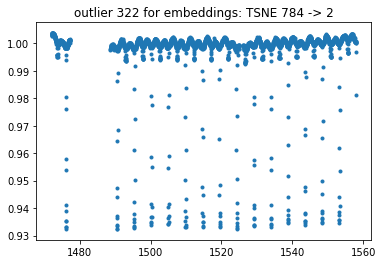

5.9520473


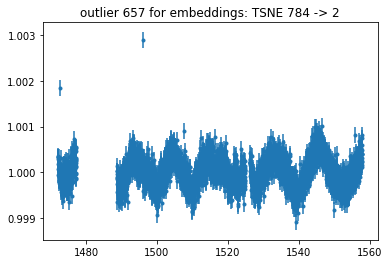

4.223113


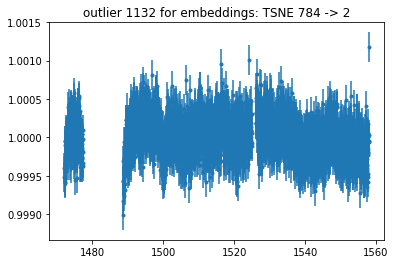

4.4107513


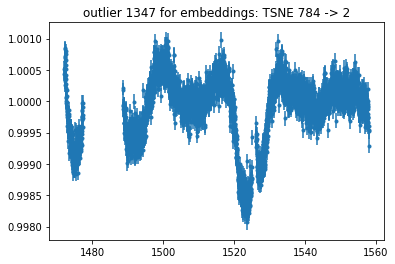

5.1290503


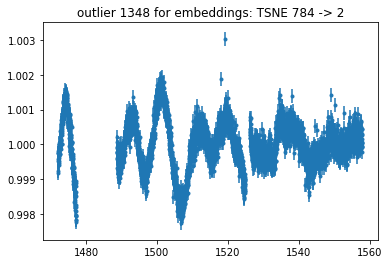

4.501403


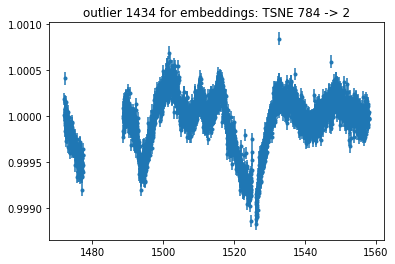

4.4010043


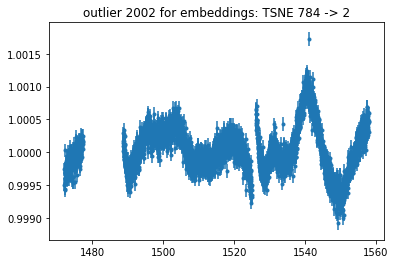

4.5066166


In [31]:
distances = pairwise_distances(embeddings_tsne_784_2)
tsne_outliers, tsne_scores, tsne_norm_distribution, tsne_raw_scores = find_outliers(distances, name="TSNE 784 -> 2", title="min distance distribution for embedding: TSNE 784 -> 2", metric='min', cutoff=4.2, savefig=True)



In [32]:
print("OUTLIERS: ")
print(tsne_outliers)
print("SCORES OF OUTLIERS:")
print(tsne_scores)
print("MEAN RAW SCORE, MEDIAN RAW SCORE")
print(str(np.mean(tsne_raw_scores)) + ", " + str(np.median(tsne_raw_scores)))
print("MEAN NORMALIZED SCORE, MEDIAN NORMALIZED SCORE")
print(str(np.mean(tsne_norm_distribution)) + ", " + str(np.median(tsne_norm_distribution)))

OUTLIERS: 
[129, 206, 322, 657, 1132, 1347, 1348, 1434, 2002]
SCORES OF OUTLIERS:
[(129, 9.034252), (206, 9.740791), (322, 5.9520473), (657, 4.223113), (1132, 4.4107513), (1347, 5.1290503), (1348, 4.501403), (1434, 4.4010043), (2002, 4.5066166)]
MEAN RAW SCORE, MEDIAN RAW SCORE
0.2204378, 0.18758136
MEAN NORMALIZED SCORE, MEDIAN NORMALIZED SCORE
4.043579e-08, -0.21749415


# TSNE vs UMAP direct distribution comparison

In [33]:
new_outliers = umap_outliers + tsne_outliers

for light_curve_index in new_outliers:
    print("light curve index: " + str(light_curve_index) + " tsne norm score: " + str(tsne_norm_distribution[light_curve_index]) + " umap norm score: " + str(umap_norm_distribution[light_curve_index]))
    
    
    
    
    

light curve index: 112 tsne norm score: 0.7464397 umap norm score: 3.701518
light curve index: 934 tsne norm score: 1.778165 umap norm score: 4.2696724
light curve index: 1132 tsne norm score: 4.4107513 umap norm score: 5.1466312
light curve index: 1317 tsne norm score: -0.38307348 umap norm score: 3.6438541
light curve index: 1347 tsne norm score: 5.1290503 umap norm score: 8.750384
light curve index: 1552 tsne norm score: 3.3028061 umap norm score: 4.134793
light curve index: 1960 tsne norm score: 0.19811027 umap norm score: 5.1549544
light curve index: 2005 tsne norm score: 1.2640842 umap norm score: 3.5425956
light curve index: 2344 tsne norm score: 0.4657598 umap norm score: 5.5921526
light curve index: 129 tsne norm score: 9.034252 umap norm score: -0.93147033
light curve index: 206 tsne norm score: 9.740791 umap norm score: 2.6252112
light curve index: 322 tsne norm score: 5.9520473 umap norm score: 2.6877525
light curve index: 657 tsne norm score: 4.223113 umap norm score: 0.98

In [34]:
np.save("embeddings_tsne.npy", embeddings_tsne_784_2)
np.save("embeddings_umap.npy", embeddings_umap_784_2)